In [19]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250


API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')



@lru_cache()
def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data

def run_backtest(strategy, symbol: str, start: datetime.date, end: datetime.date, params, cash: float):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

  data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
  feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed1)
 
  results = cerebro.run()

  cerebro.plot(iplot=True)

  strat = results[0]
  return strat

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100



In [20]:
symbol = 'NRGU'
start = datetime.date(2021, 10, 1)
end = datetime.date(2022, 5, 31)
cash = 5000

In [30]:
class MyStrategy(bt.Strategy):
    params = dict(
      level_divisor=20,
      take_profit_levels_up=2,
      stop_loss_levels_down=2,
      verbose=False,
    )

    def __init__(self):
      self.occupations = {}


    def log(self, *message):
      if self.p.verbose:
        print(self.data.datetime.datetime(0), *message)

    def next(self):
      level_to_occupy = round(self.data.close[0] / self.p.level_divisor)

      if level_to_occupy > 40:
        return

      now = self.data.datetime.datetime(0)
      if level_to_occupy in self.occupations:
        # if already entered
        if self.occupations[level_to_occupy]['size'] != 0:
          return

        # if recently attempted entry
        if self.occupations[level_to_occupy]['size'] < 1 and now - self.occupations[level_to_occupy]['time'] < datetime.timedelta(minutes=10):
          return
        
        self.log(f"evacuating {level_to_occupy} due to lack of fill")
        # we entered a while back and still have not been filled, let's exit
        self.occupations[level_to_occupy]['order'].cancel()
        del self.occupations[level_to_occupy]
      
      self.occupations[level_to_occupy] = {
        'size': 0,
        'time': now,
      }
      size = 1000 // self.data.close[0]
      orders = self.buy_bracket(size=size,
        limitprice=self.data.close[0] + (self.p.take_profit_levels_up*self.p.level_divisor),
        stopprice=self.data.close[0] - (self.p.stop_loss_levels_down*self.p.level_divisor),
        tradeid=level_to_occupy)
      self.occupations[level_to_occupy]['order'] = orders[0]
    
    def notify_order(self, order: bt.Order):
      if order.status not in (bt.Order.Completed, bt.Order.Partial):
        return
      
      self.occupations[order.tradeid]['size'] += order.executed.size
      if 'order' in self.occupations[order.tradeid]:
        del self.occupations[order.tradeid]['order']
      if 'time' in self.occupations[order.tradeid]:
        del self.occupations[order.tradeid]['time']
      
      if self.occupations[order.tradeid]['size'] < 1:
        del self.occupations[order.tradeid]

      self.log(self.occupations)


2021-10-01 09:31:00 {7: {'size': 6.0}}
2021-10-01 09:32:00 {7: {'size': 6.0}, 8: {'size': 6.0}}
2021-10-04 09:46:00 {7: {'size': 6.0}, 8: {'size': 6.0}, 9: {'size': 5.0}}
2021-10-08 10:37:00 evacuating 10 due to lack of fill
2021-10-08 10:38:00 {7: {'size': 6.0}, 8: {'size': 6.0}, 9: {'size': 5.0}, 10: {'size': 5.0}}
2021-10-25 09:30:00 {8: {'size': 6.0}, 9: {'size': 5.0}, 10: {'size': 5.0}}
2021-10-25 09:30:00 {9: {'size': 5.0}, 10: {'size': 5.0}}
2021-10-25 09:31:00 {9: {'size': 5.0}, 10: {'size': 5.0}, 11: {'size': 4.0}}
2021-11-18 10:12:00 {9: {'size': 5.0}, 10: {'size': 5.0}, 11: {'size': 4.0}, 8: {'size': 5.0}}
2021-11-19 15:43:00 {9: {'size': 5.0}, 10: {'size': 5.0}, 11: {'size': 4.0}, 8: {'size': 5.0}, 7: {'size': 6.0}}
2021-12-20 09:30:00 {9: {'size': 5.0}, 10: {'size': 5.0}, 8: {'size': 5.0}, 7: {'size': 6.0}}
2021-12-20 09:35:00 {9: {'size': 5.0}, 10: {'size': 5.0}, 8: {'size': 5.0}, 7: {'size': 6.0}, 6: {'size': 7.0}}
2022-01-04 09:37:00 {9: {'size': 5.0}, 10: {'size': 5.0}

<IPython.core.display.Javascript object>

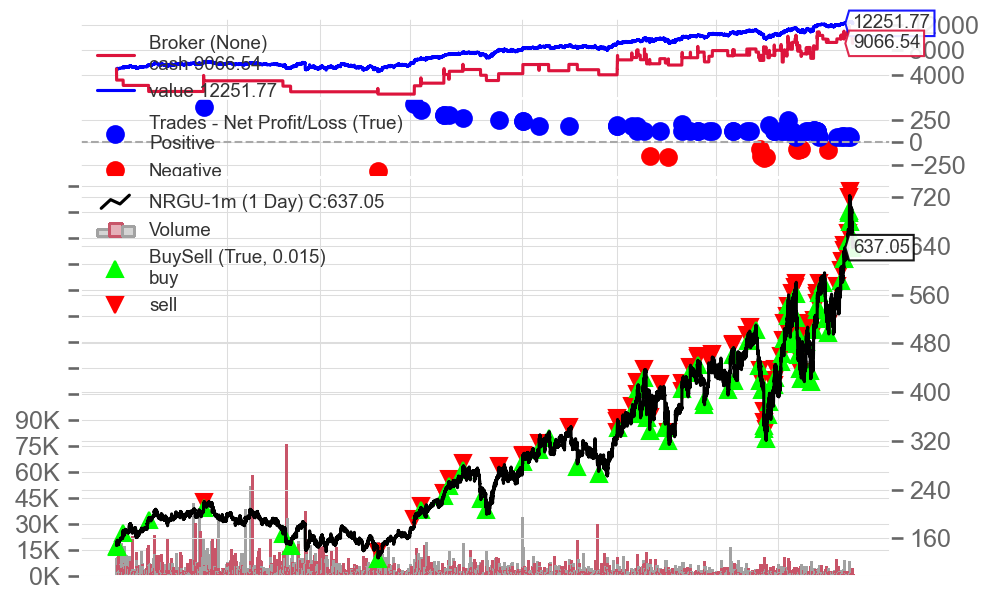

In [39]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {'level_divisor': 20, 'take_profit_levels_up': 3, 'stop_loss_levels_down': 4, 'verbose': True}
  , cash
)

# Detail

In [40]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
print(strategy.p.__dict__)
print(f"ROI     : {get_roi(strategy):.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")

{'level_divisor': 20, 'take_profit_levels_up': 3, 'stop_loss_levels_down': 4, 'verbose': True}
ROI     : 145.0%
Drawdown: 26.2%
Average : 83 trades @ 96.00
Winners : 74.7% @ 157.01
Losers  : 19.3% @ -140.39


In [41]:
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.basic(returns)

                    Strategy
------------------  ----------
Start Period        2021-10-01
End Period          2022-05-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   145.04%
CAGR﹪              286.42%

Sharpe              3.13
Sortino             5.13
Sortino/√2          3.63
Omega               1.74

Max Drawdown        -20.46%
Longest DD Days     69

Gain/Pain Ratio     0.74
Gain/Pain (1M)      8.69

Payoff Ratio        1.35
Profit Factor       1.74
Common Sense Ratio  2.85
CPC Index           1.32
Tail Ratio          1.64
Outlier Win Ratio   3.47
Outlier Loss Ratio  3.95

MTD                 17.9%
3M                  43.56%
6M                  135.56%
YTD                 121.6%
1Y                  145.04%
3Y (ann.)           286.42%
5Y (ann.)           286.42%
10Y (ann.)          286.42%
All-time (ann.)     286.42%

Avg. Drawdown       -2.69%
Avg. Drawdown Days  6
Recovery Factor     7.09
Ulcer Index         0.06
Serenity Index      5.65


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results("rungs", [types.FilledOrder(intention=None, symbol=t['symbol'], quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')], metadata.Metadata(commit_id="", last_updated=datetime.datetime.now()))

# TODO: adjust account simulator to work with orders instead of trades (since this algo is in nearly 100% of the time)

# Optimize

In [33]:
gridsearch = dict(
    level_divisor=[10, 15, 20, 25, 30, 40, 50, 60],
    take_profit_levels_up=[1, 2, 3],
    stop_loss_levels_down=[1, 2, 3, 4],
    verbose=[False],
)

time_per = datetime.timedelta(seconds=13)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")

data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
cerebro.adddata(feed1)

runs = cerebro.run()
backtest_results = [results[0] for results in runs]



end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

Estimated time (@ 0:00:13, 96): 0:20:48
(ending at 2022-06-09 11:24:28.399812)
Done. Took 0:20:10.832845
time per: 0:00:12.612842


In [34]:
import pandas as pd

def build_row(strategy):
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  row = {
    'roi': get_roi(strategy),
    'drawdown': get_max_drawdown(strategy),
    'trades': analysis['total']['total'],
    'average_$': analysis['pnl']['gross']['average'],
    'win_rate': analysis['won']['total'] / analysis['total']['total'],
    'average_win_$': analysis['won']['pnl']['average'],
    'average_loss_$': analysis['lost']['pnl']['average'],
    'params': strategy.p.__dict__
  }
  row.update(strategy.p.__dict__)
  return row
results = pd.DataFrame([build_row(strategy) for strategy in sorted(backtest_results, key=get_roi, reverse=True) if strategy.analyzers.tradeanalyzer.get_analysis()['total']['total'] > 0])

In [35]:
results

,roi,drawdown,trades,average_$,win_rate,average_win_$,average_loss_$,params,level_divisor,take_profit_levels_up,stop_loss_levels_down,verbose
0,1.450354,0.262315,83,96.001486,0.746988,157.006648,-140.393519,"{'level_divisor': 20, 'take_profit_levels_up':...",20,3,4,False
1,1.284225,0.245131,93,72.345691,0.666667,156.495624,-113.986304,"{'level_divisor': 20, 'take_profit_levels_up':...",20,3,3,False
2,1.247598,0.251275,14,566.761618,0.785714,566.761618,0.000000,"{'level_divisor': 60, 'take_profit_levels_up':...",60,3,3,False
3,1.247598,0.251275,14,566.761618,0.785714,566.761618,0.000000,"{'level_divisor': 60, 'take_profit_levels_up':...",60,3,4,False
4,1.229598,0.319465,52,132.677581,0.769231,192.908607,-168.477550,"{'level_divisor': 25, 'take_profit_levels_up':...",25,3,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.579389,0.124508,137,22.258507,0.737226,66.558902,-109.339724,"{'level_divisor': 25, 'take_profit_levels_up':...",25,1,2,False
92,0.569171,0.117396,496,5.737608,0.528226,43.160141,-36.162835,"{'level_divisor': 15, 'take_profit_levels_up':...",15,1,1,False
93,0.530529,0.140970,102,26.466864,0.578431,105.922064,-85.148774,"{'level_divisor': 40, 'take_profit_levels_up':...",40,1,1,False
94,0.514614,0.120939,498,5.166802,0.544177,38.088740,-34.136480,"{'level_divisor': 10, 'take_profit_levels_up':...",10,1,1,False


<IPython.core.display.Javascript object>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


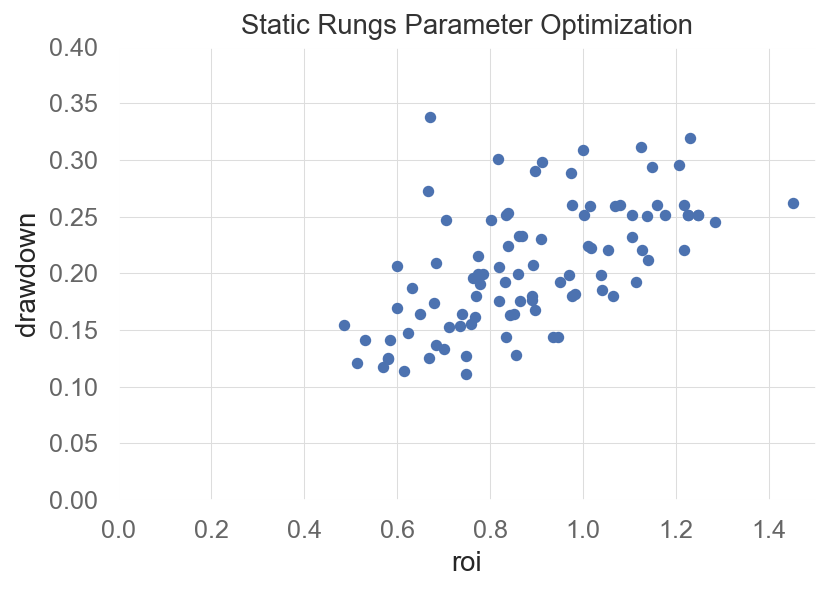

In [58]:
mpl.rcParams['figure.dpi'] = 150
results.plot(x='roi', y='drawdown', kind='scatter', xlim=(0, 1.5), ylim=(0, .4), title='Static Rungs Parameter Optimization')